In [1]:
pip install pulp


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
import re

In [3]:
df = pd.read_csv("Car Sales.xlsx.csv")
df

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23901,C_CND_023902,12/31/2023,Martin,Male,13500,C & M Motors Inc,Plymouth,Voyager,Overhead Camshaft,Manual,Red,12000,60504-7114,Passenger,8583598,Pasco
23902,C_CND_023903,12/31/2023,Jimmy,Female,900000,Ryder Truck Rental and Leasing,Chevrolet,Prizm,DoubleÂ Overhead Camshaft,Auto,Black,16000,06457-3834,Hardtop,7914229,Middletown
23903,C_CND_023904,12/31/2023,Emma,Male,705000,Chrysler of Tri-Cities,BMW,328i,Overhead Camshaft,Manual,Red,21000,99301-3882,Sedan,7659127,Scottsdale
23904,C_CND_023905,12/31/2023,Victoire,Male,13500,Chrysler Plymouth,Chevrolet,Metro,DoubleÂ Overhead Camshaft,Auto,Black,31000,53546-9427,Passenger,6030764,Austin


In [4]:
DATA_PATH = "Car Sales.xlsx.csv"
BUDGET = 500000          # Max money available to purchase cars (assumption)
MAX_TOTAL_CARS = 20      # Max total number of cars dealership can sell (assumption)
COST_SHARE = 0.70        # Assumed cost = 70% of selling price -> profit = 30%
TOP_MODELS = 20         # Keep only top N profitable models
TIME_LIMIT = 30         # Solver time limit in seconds

In [5]:
df = pd.read_csv(DATA_PATH)
price_col_candidates = [c for c in df.columns if 'price' in c.lower()]
if not price_col_candidates:
    raise ValueError("Couldn't find a price column.")
price_col = price_col_candidates[0]

def to_numeric(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = re.sub(r'[^\d.\-]', '', s)
    try:
        return float(s)
    except:
        return np.nan

df['Price_clean'] = df[price_col].apply(to_numeric)
df = df.dropna(subset=['Price_clean'])

In [6]:
# Aggregate by Model
agg = df.groupby('Model').agg(
    AvgPrice=('Price_clean', 'mean'),
    AvailableUnits=('Model', 'count')
).reset_index()

agg['ProfitPerUnit'] = (1 - COST_SHARE) * agg['AvgPrice']

In [7]:
# Keep only top profitable models
agg = agg.sort_values('ProfitPerUnit', ascending=False).head(TOP_MODELS).reset_index(drop=True)

In [8]:
# Build LP Model
model = pulp.LpProblem("Car_Dealership_Profit_Maximization", pulp.LpMaximize)

In [9]:
# Continuous decision variables for speed
vars_sell = {
    row['Model']: pulp.LpVariable(f"Sell_{i}", lowBound=0, upBound=int(row['AvailableUnits']), cat='Continuous')
    for i, row in agg.iterrows()
}

In [10]:
# Objective: maximize total profit
model += pulp.lpSum([vars_sell[row['Model']] * row['ProfitPerUnit'] for _, row in agg.iterrows()])


In [11]:
# Constraints
model += pulp.lpSum([vars_sell[row['Model']] * row['AvgPrice'] * COST_SHARE for _, row in agg.iterrows()]) <= BUDGET
model += pulp.lpSum([vars_sell[m] for m in vars_sell]) <= MAX_TOTAL_CARS

In [12]:
# Solve with time limit
solver = pulp.PULP_CBC_CMD(msg=0, timeLimit=TIME_LIMIT)
model.solve(solver)

1

In [13]:
# Prepare results
solution = []
for _, row in agg.iterrows():
    m = row['Model']
    qty = pulp.value(vars_sell[m])
    if qty is None: qty = 0
    qty = round(qty)  # round after solving
    profit = qty * row['ProfitPerUnit']
    cost = qty * row['AvgPrice'] * COST_SHARE
    revenue = qty * row['AvgPrice']
    solution.append({
        'Model': m,
        'SellUnits': qty,
        'AvgPrice': row['AvgPrice'],
        'ProfitPerUnit': row['ProfitPerUnit'],
        'TotalProfit': profit,
        'TotalCost': cost,
        'TotalRevenue': revenue
    })

sol_df = pd.DataFrame(solution)
sol_df = sol_df[sol_df['SellUnits'] > 0].sort_values('TotalProfit', ascending=False).reset_index(drop=True)


In [17]:
# Print summary
status = pulp.LpStatus[model.status]
print(f"Solver status: {status}")
print(f"Total cars to sell: {sol_df['SellUnits'].sum()} / {MAX_TOTAL_CARS}")
print(f"Total profit: ${sol_df['TotalProfit'].sum():,.2f}")
print(f"Total cost: ${sol_df['TotalCost'].sum():,.2f}")
print(f"Total revenue: ${sol_df['TotalRevenue'].sum():,.2f}\n")

if not sol_df.empty:
    print("Optimal Sales Plan:")
    print(sol_df[['Model', 'SellUnits', 'TotalProfit']].to_string(index=False))

Solver status: Optimal
Total cars to sell: 13 / 20
Total profit: $221,664.04
Total cost: $517,216.09
Total revenue: $738,880.13

Optimal Sales Plan:
 Model  SellUnits  TotalProfit
Catera         13    221664.04


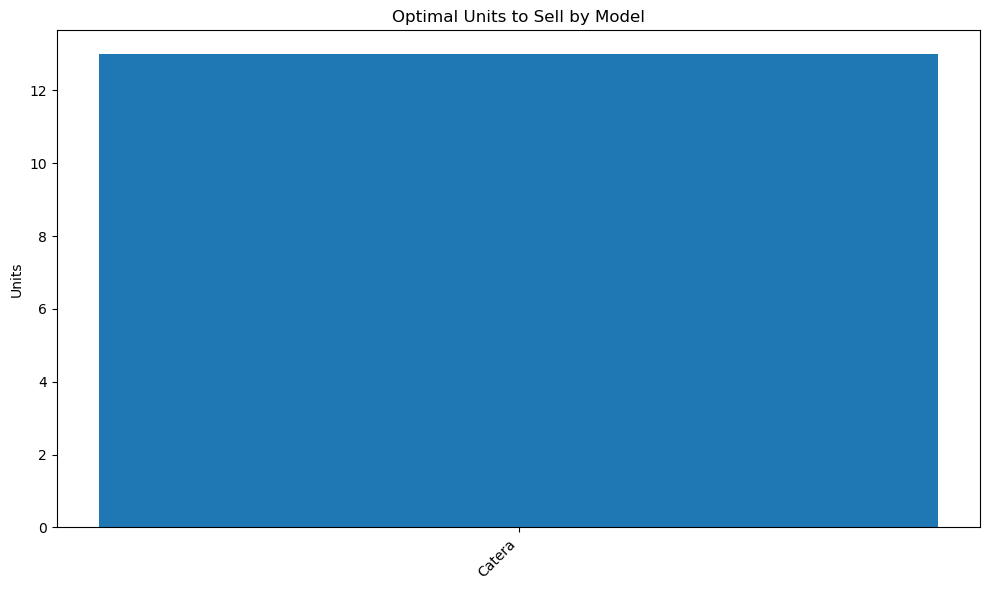

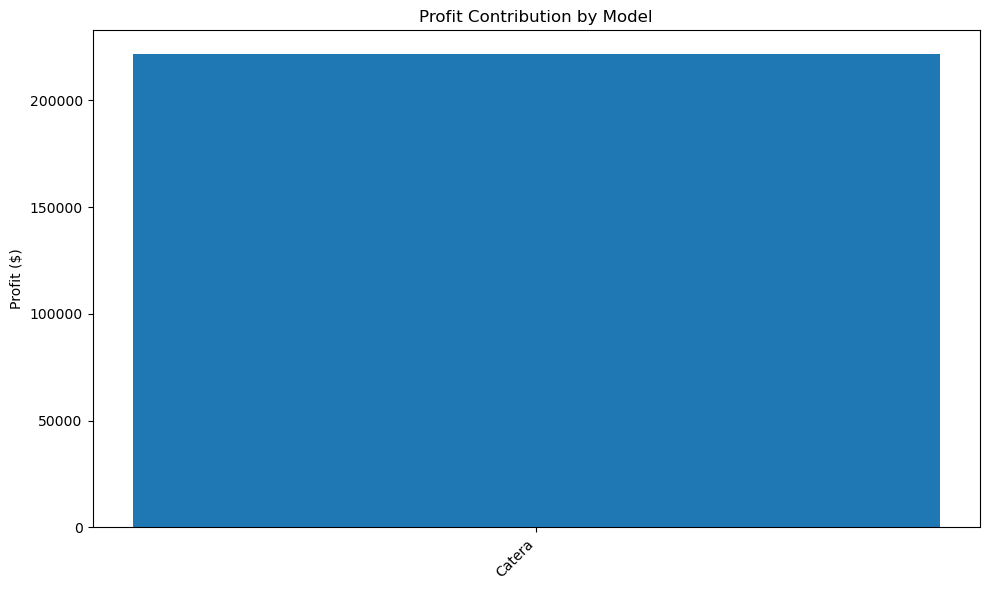

In [20]:
# Visualizations
if not sol_df.empty:
    plt.figure(figsize=(10,6))
    plt.bar(sol_df['Model'], sol_df['SellUnits'])
    plt.xticks(rotation=45, ha='right')
    plt.title("Optimal Units to Sell by Model")
    plt.ylabel("Units")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.bar(sol_df['Model'], sol_df['TotalProfit'])
    plt.xticks(rotation=45, ha='right')
    plt.title("Profit Contribution by Model")
    plt.ylabel("Profit ($)")
    plt.tight_layout()
    plt.show()